## <u>Bayesian GAM of Southern Ocean Chlorophyll Time Series</u>:
### <u>Part I - Single Zone Time Series</u>
by Erdem M. Karaköylü


<img src='../../figjar/npp_southern_ocean.jpg' width=300, height=300/>

### <u>Summary</u>
This notebook documents the development of alternative Bayesian Generalized Additive Models (GAM) to determine the components, such as trend, that make up a time series of chlorophyll. The region of interest is the Southern Ocean (SO). In particular, I focus on the Atlantic Ocean Sub-Tropical Zone (AOSTZ). The entire study follows a now [published paper](https://doi.org/10.1029/2019GL083163) on chlorophyll in the SO based on a shorter time series.

The progression of the notebook follows a increasing degree of complexity in the model design that I then fit the data. I use evaluation criteria that take the entire prediction posterior distribution of a model to estimate its predictive skill on out-of-sample data. These criteria include the Widely Available Information Criterion (WAIC) and the Pareto-Smoothed Importance Sampling Leave-One-Out Cross Validation (PSIS-LOOCV). I compare these criteria to select the better performing model or models.

I models below are coded in Python, using the probabilistic programming library [PyMC3](https://docs.pymc.io/).

In [1]:
# Import necessary library
import pathlib
import pickle
from collections import namedtuple

import pandas as pd
import numpy as np
from numpy import pi as π
from sklearn.preprocessing import StandardScaler, scale

import pymc3 as pm
import theano.tensor as tt

import matplotlib.pyplot as pl
import matplotlib.dates as mdates
from matplotlib import rcParams
import arviz as ar

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [11]:
# Graphical settings
%matplotlib inline

years = mdates.YearLocator(day=1)
months = mdates.MonthLocator(bymonthday=1)
rcParams['xtick.major.size'] = 8
rcParams['xtick.minor.size'] = 4
rcParams['xtick.minor.visible'] = True
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['axes.titlesize'] = 18
rcParams['axes.formatter.limits'] = (-3, 2)

The data is stored in a serialized (pickled) tabular [pandas](https://pandas.pydata.org/) dataframe and is loaded below

In [ ]:
df = pd.read_pickle('../../pickleJar/df.pkl')

In [7]:
#quick formatting to remove empty spaces in column names
df.rename(columns={col: col.strip() for col in df.columns}, inplace=True)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 248 entries, 1997-09-01 to 2018-04-01
Data columns (total 14 columns):
sam        248 non-null float64
aao        248 non-null float64
iostz      248 non-null float64
iosostz    248 non-null float64
postz      248 non-null float64
posostz    248 non-null float64
aostz      248 non-null float64
aosostz    248 non-null float64
iopooz     241 non-null float64
popooz     188 non-null float64
aopooz     248 non-null float64
iosaaz     248 non-null float64
posaaz     248 non-null float64
aosaaz     248 non-null float64
dtypes: float64(14)
memory usage: 29.1 KB


The dataframe above contains time series 14 zones by which SO was divided. Their statistical properties are displayed below:

In [4]:
df.describe().T

count      mean       std       min       25%       50%       75%  \
sam      248.0  0.519879  1.701669 -5.770000 -0.642500  0.580000  1.652500   
aao      248.0  0.175113  0.973178 -2.798000 -0.448250  0.197000  0.884500   
iostz    248.0  0.213579  0.027127  0.142600  0.194450  0.217491  0.233288   
iosostz  248.0  0.216339  0.058586  0.147280  0.174935  0.201763  0.239613   
postz    248.0  0.201598  0.048607  0.110340  0.164000  0.197431  0.231166   
posostz  248.0  0.237798  0.107210  0.119390  0.163355  0.186825  0.289744   
aostz    248.0  0.292012  0.043535  0.199870  0.261736  0.281545  0.315765   
aosostz  248.0  0.363231  0.125154  0.182640  0.266058  0.342921  0.444249   
iopooz   241.0  0.197709  0.070319  0.128662  0.164502  0.180248  0.221227   
popooz   188.0  0.193421  0.057796  0.112061  0.150147  0.171223  0.226092   
aopooz   248.0  0.345294  0.147801  0.163787  0.246054  0.311200  0.409819   
iosaaz   248.0  0.213654  0.034287  0.158629  0.187442  0.208735  0.234868   
posaaz   248.0  0.184731  0.022662  0.134620  0.170730  0.183385  0.197011   
aosaaz   248.0  0.441675  0.141194  0.218980  0.326484  0.423374  0.540948   

              max  
sam      4.920000  
aao      2.573000  
iostz    0.287270  
iosostz  0.641870  
postz    0.335140  
posostz  0.639570  
aostz    0.415390  
aosostz  0.969560  
iopooz   1.067500  
popooz   0.384627  
aopooz   1.422800  
iosaaz   0.332510  
posaaz   0.253160  
aosaaz   0.906591

I chose to use the AOSTZ timeseries as it is relatively clean and is not missing observations. The data is displayed below. 

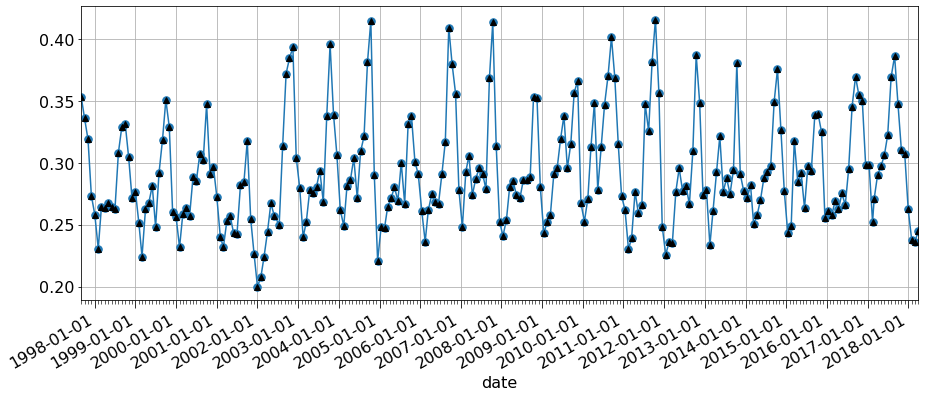

In [13]:
_, ax = pl.subplots(figsize=(15, 6))
df.aostz.plot(marker='.', ax=ax, markersize=15)
df.aostz.interpolate().plot(ls='', marker='^', color='k', ax=ax);
ax.xaxis_date()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months)
ax.grid()

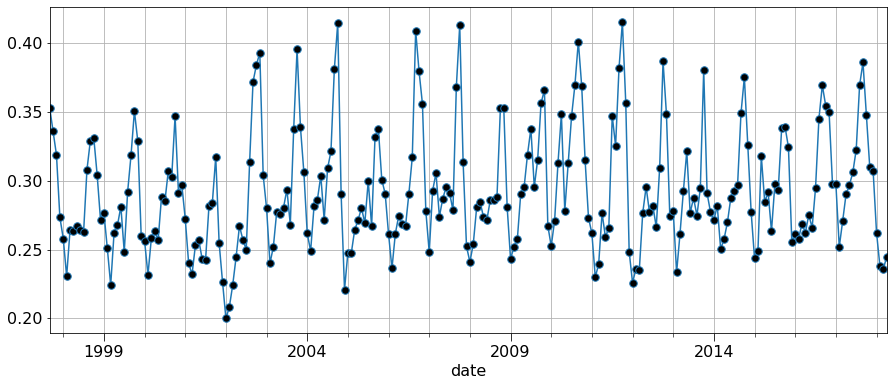

In [15]:
d_aostz.plot(figsize=(15, 6), marker='.', markerfacecolor='k', markersize=15);
pl.grid(which='both');

#### <u>Extracting and Standardizing the Data</u>

Model fitting is often best served by standardizing the data; namely, subtracting the mean and dividing by the standard deviation:

In [16]:
d_aostz = df['aostz'].resample('MS').mean().interpolate()
x = np.arange(d_aostz.size)
std_scaler = StandardScaler()
y_s = std_scaler.fit_transform(d_aostz.values[:,None])
y_s = y_s.flatten()

### <u>Model types and helper functions</u>
In order to avoid rewriting model definition code, I wrote a few functions to automate model creation. Three types of models, which are experimented with are wrapped in Python functions below:
1. Global linear trend only. This is essentially a linear regression model.
2. Global linear trend and fourier series-based seasonal cycle. Note that the number of fourier components can be specified during model instantiation.
3. Global trend, seasonal cyle and lag-1 autoregressive model.

In addition a fourier series helper function is also available to reduce code when fitting the seasonal cycle.

In [29]:
def mdl_trend_only(m):
    """
    m [pymc3 Model class]: model object
    """
    with m:
        σ = pm.Exponential('σ', 1)
        slp = pm.Normal('slope', 0, 1)
        itc = pm.Normal('intercept', 0, 1)
        μ = itc + slp * x
        y_lik = pm.Normal('y_lik', mu=μ, sd=σ, observed=y_s)

        
def fourier_series(x, p=12, n=1):
    wls = 2 * π * np.arange(1, n+1) / p
    newx = wls * x[:, None]
    sinusoids = np.concatenate((np.cos(newx), np.sin(newx)), axis=1)
    return sinusoids


def mdl_season_only(m, n_fourier):
    """
    m [pymc3 Model class]: model object
    n_fourier [int]: number of fourier components
    """
    with m:
        σ = pm.Exponential('σ', 1)
        f_coefs = pm.Normal('fourier_coefs', 0, sd=1, shape=(n_fourier*2))
        season = tt.dot(fourier_series(x, n=n_fourier), f_coefs)
        #tau = pm.Gamma('tau', 10, 2) 
        #y_lik = pm.StudentT('y_lik', mu=season, lam=tau, nu=nu_, observed=y_s)
        y_lik = pm.Normal('y_lik', mu=season, sd=σ, observed=y_s)

        
def mdl_trend_season(m, n_fourier):
    """
    m [pymc3 Model class]: model object
    n_fourier [int]: number of fourier components
    """
    with m:
        #season estimation
        f_coefs = pm.Normal('fourier_coefs', 0, sd=1, shape=(n_fourier*2))
        season = tt.dot(fourier_series(x, n=n_fourier), f_coefs)
        
        # linear trend estimation
        slp = pm.Normal('slope', 0, 1)
        itc = pm.Normal('intercept', 0, 1)
        trend = pm.Deterministic('trend', itc + slp * x)

        σ = pm.Exponential('σ', 1)
        
        μ = pm.Deterministic('mu', trend + season)
        y_lik = pm.Normal('y_lik', mu=μ, sd=σ, observed=y_s)

        
def mdl_trend_season_ar1(m, n_fourier):
    """
    m [pymc3 Model class]: model object
    n_fourier [int]: number of fourier components
    """
    with m:
        
        #season estimation
        f_coefs = pm.Normal('fourier_coefs', 0, sd=1, shape=(n_fourier*2))
        season = tt.dot(fourier_series(x, n=n_fourier), f_coefs)
        
        # linear trend estimation
        slp = pm.Normal('slope', 0, 1)
        itc = pm.Normal('intercept', 0, 1)
        trend = pm.Deterministic('trend', itc + slp * x)
        
        # residual estimation
        k_ = pm.Uniform('k', -1.1, 1.1)
        tau_ = pm.Gamma('tau', 10, 3)
        ar1 = pm.AR1('ar1', k=k_, tau_e=tau_, shape=y_s.size)
        
        σ = pm.Exponential('σ', 1)
        
        μ = pm.Deterministic('mu', trend + season + ar1)
        y_lik = pm.Normal('y_lik', mu=μ, sd=σ, observed=y_s)

### <u>Model Implementations</u>
#### 1. <u>Linear Trend Model</u>

In [32]:
m1 = pm.Model()
mdl_trend_only(m1)
with m1:
    trace_1 = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, σ]
Sampling 4 chains: 100%|██████████| 28000/28000 [00:12<00:00, 2233.48draws/s]


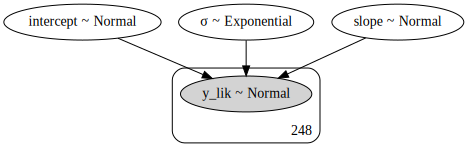

In [31]:
render = pm.model_to_graphviz(m1)
render.format = 'png'
render.render('model1_linear_trend', directory='../../figjar/')

A [Kruschke](https://www.elsevier.com/books/doing-bayesian-data-analysis/kruschke/978-0-12-405888-0) diagram summarizes the linear trend model structure below:
<img src='../../figjar/model1_linear_trend.png' />

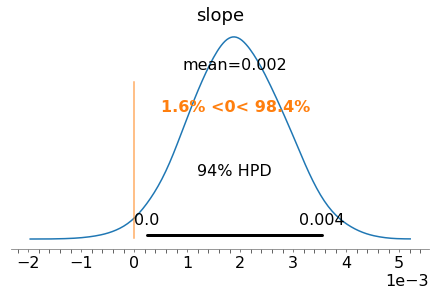

In [36]:
pm.plot_posterior(trace_1, var_names=['slope'], round_to=3, ref_val=0);

In [37]:
m1.name = 'm1_trend_only'
dict_final_comparison={m1: trace_1}

#### 2. <u>Fourier-based seasonal cycle models</u>
Below I try a number of models differing in the number of fourier components used in the approximation. Initially I forego the trend and focus on the seasonal cycle only<br>
\\(\rightarrow\\)3 fourier components (6 coefficients):

In [38]:
m2_f3 = pm.Model()
mdl_season_only(m2_f3, n_fourier=3)

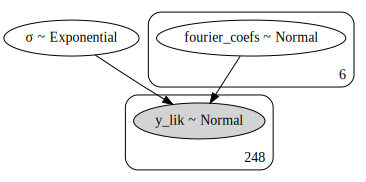

In [39]:
render2 = pm.model_to_graphviz(m2_f3)
render2.format='png'
render2.render('fourier_only', directory='../../figjar/')

Kruschke diagram of the seasonaly cycle-only model:

<img src='../../figjar/fourier_only.png />

In [46]:
with m2_f3:
    trace_m2f3 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [fourier_coefs, σ]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:09<00:00, 4024.23draws/s]


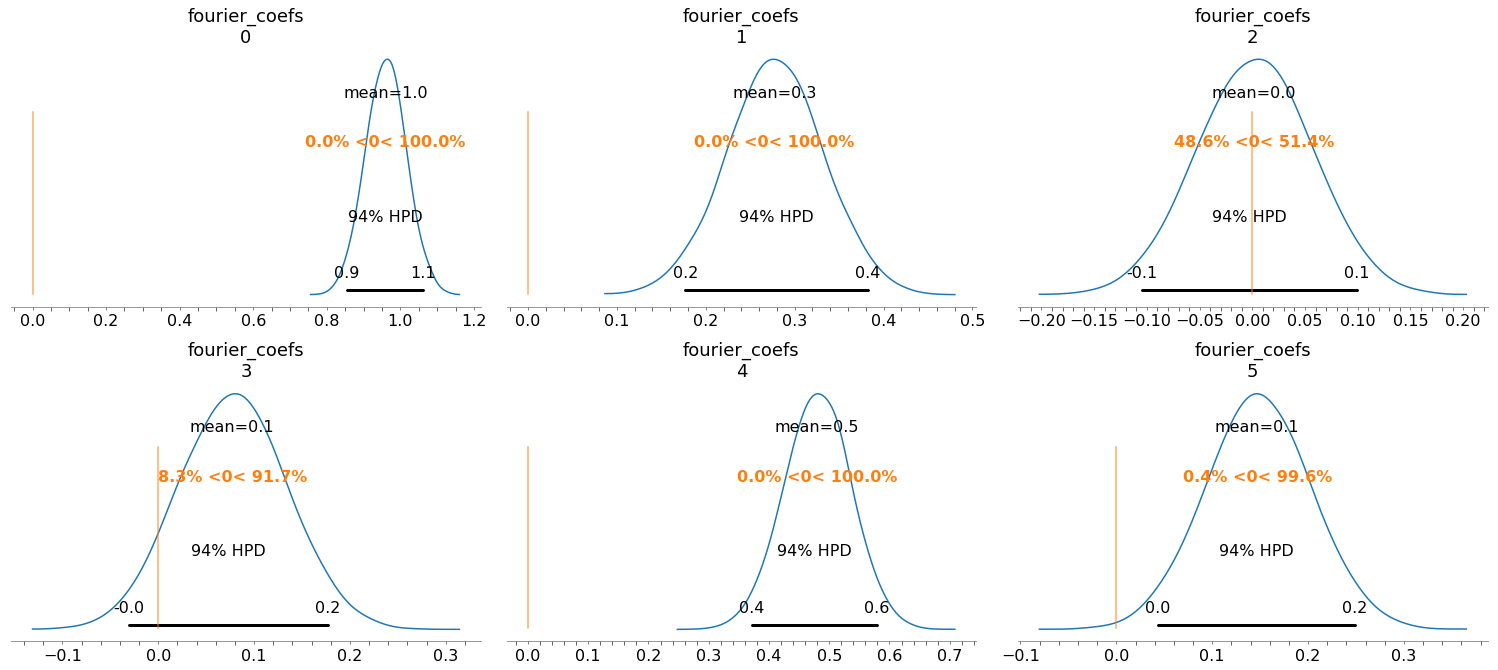

In [42]:
pm.plot_posterior(trace_m2f3, var_names=['fourier_coefs'], ref_val=0);

5 fourier components (10 coefficients)

In [43]:
m2_f5 = pm.Model()
mdl_season_only(m2_f5, n_fourier=5)

In [44]:
with m2_f5:
    trace_m2f5 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [fourier_coefs, σ]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:16<00:00, 2452.81draws/s]


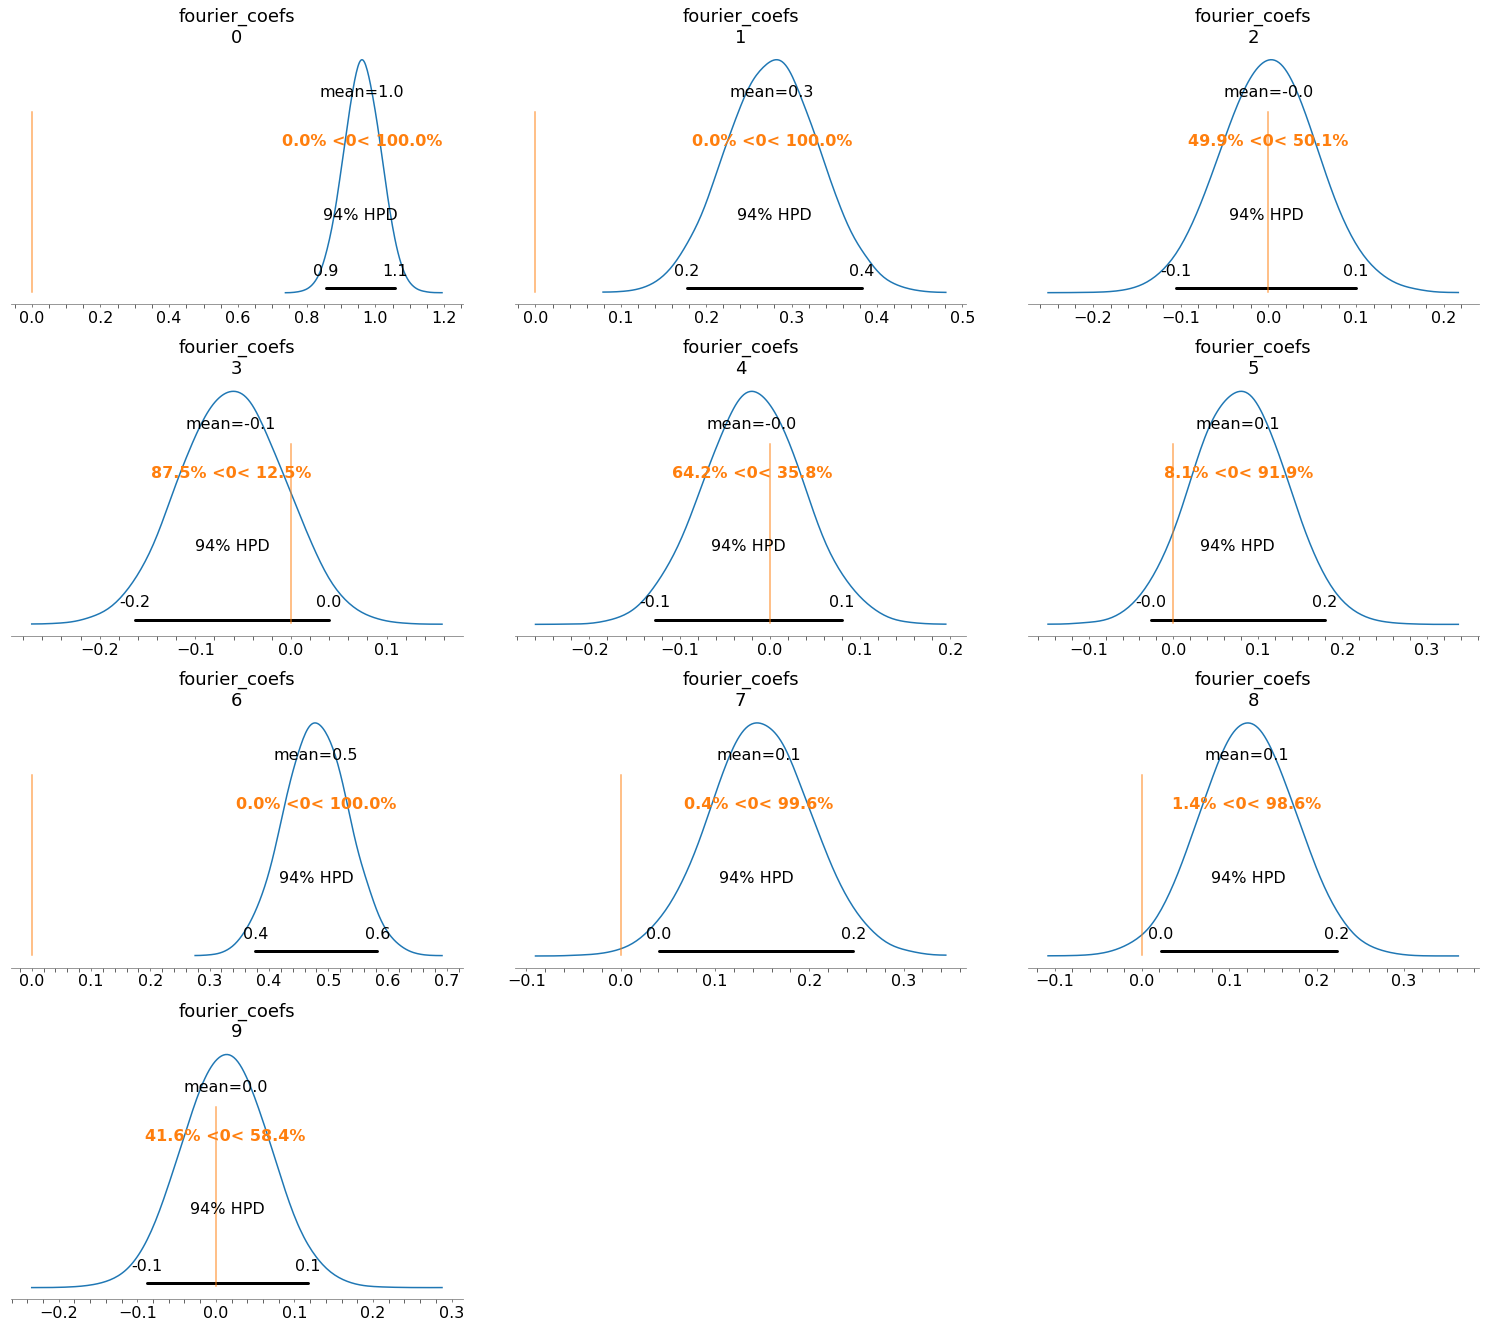

In [47]:
pm.plot_posterior(trace_m2f5, var_names=['fourier_coefs'], ref_val=0);

7 fourier components

In [48]:
m2_f7 = pm.Model()
mdl_season_only(m2_f7, n_fourier=7)

In [49]:
with m2_f7:
    trace_m2f7 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [fourier_coefs, σ]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:54<00:00, 738.42draws/s]


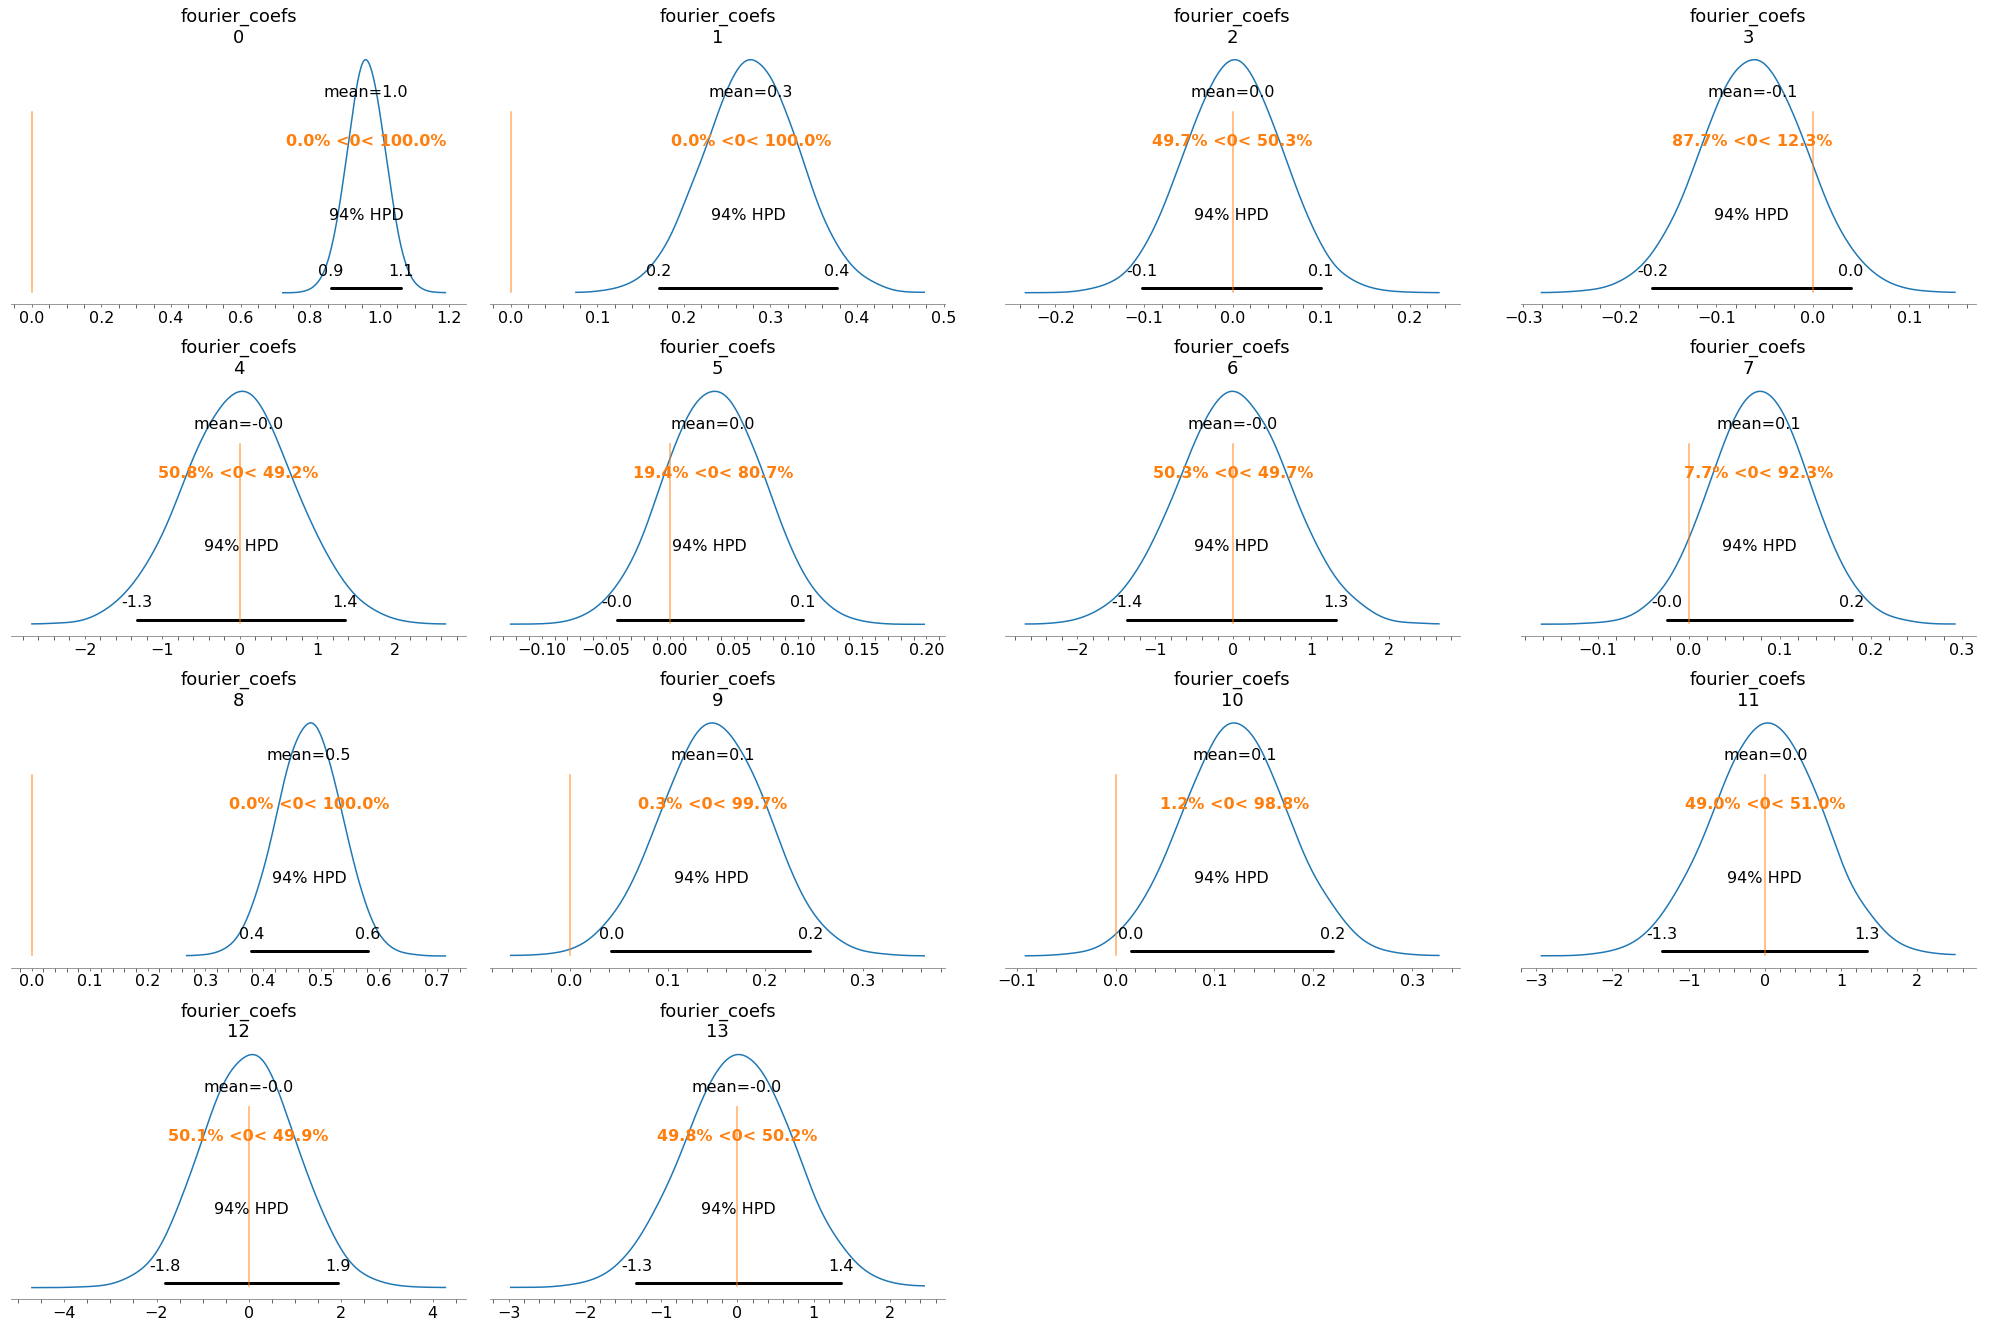

In [50]:
pm.plot_posterior(trace_m2f7, var_names=['fourier_coefs'], ref_val=0);

4 fourier components

In [51]:
m2_f4 = pm.Model()
mdl_season_only(m2_f4, n_fourier=4)

In [52]:
with m2_f4:
    trace_m2f4 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [fourier_coefs, σ]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:11<00:00, 3383.50draws/s]


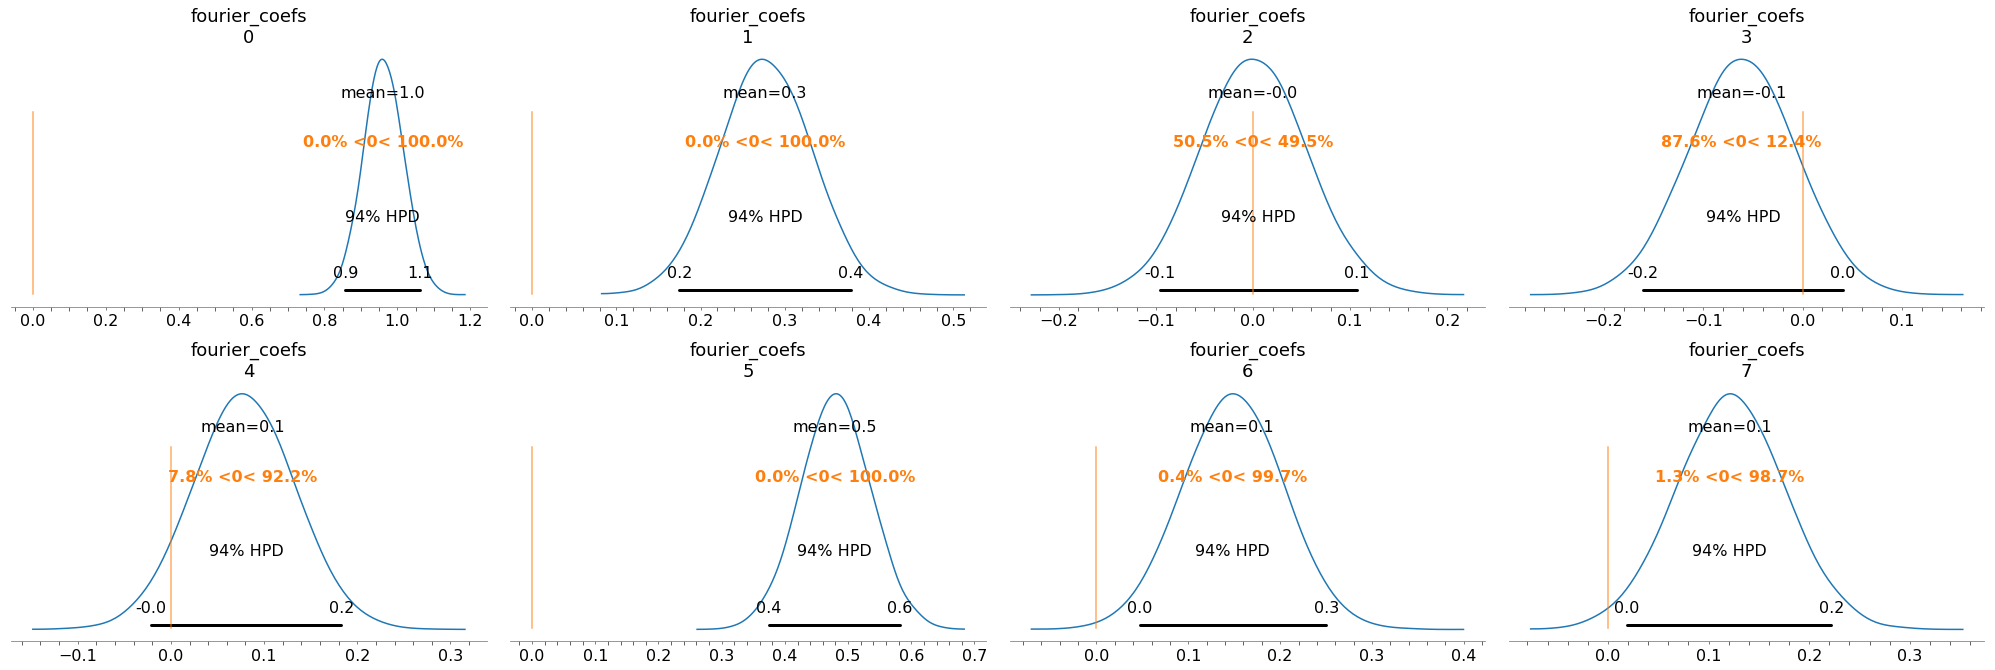

In [53]:
pm.plot_posterior(trace_m2f4, var_names=['fourier_coefs'], ref_val=0);

In [54]:
m2_f1 = pm.Model()
mdl_season_only(m2_f1, n_fourier=1)

In [55]:
with m2_f1:
    trace_m2f1 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [fourier_coefs, σ]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:07<00:00, 5648.72draws/s]


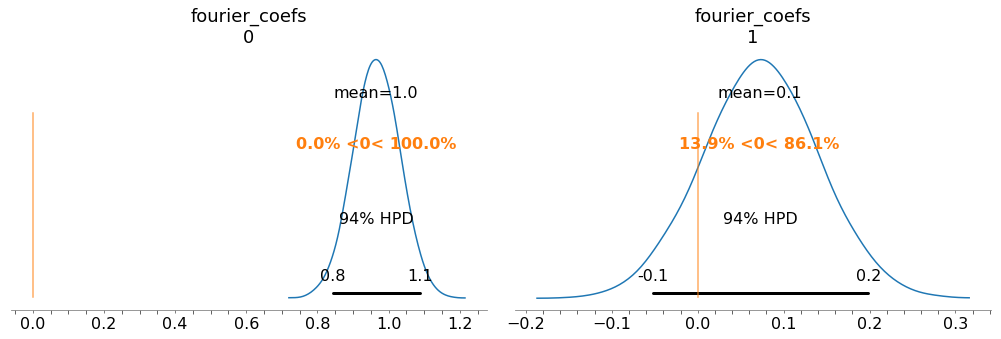

In [56]:
pm.plot_posterior(trace_m2f1, var_names=['fourier_coefs'], ref_val=0);

In [58]:
m2_f1.name = 'm_fourier_N1'
m2_f3.name = 'm_fourier_N3'
m2_f4.name = 'm_fourier_N4'
m2_f5.name = 'm_fourier_N5'
m2_f7.name = 'm_fourier_N7'

In [59]:
dict_fourier = {m2_f1: trace_m2f1, m2_f3: trace_m2f3,
                m2_f4: trace_m2f4, m2_f5: trace_m2f5,
                m2_f7: trace_m2f7}
pm.compare(dict_fourier)

WAIC  pWAIC  dWAIC weight     SE    dSE var_warn
m_fourier_N4   461.7    8.9      0   0.68  23.54      0        0
m_fourier_N3  463.86   6.87   2.16   0.32   23.5   4.99        0
m_fourier_N5  465.64  10.79   3.94      0  23.55   0.92        0
m_fourier_N7  466.79   11.7   5.09      0  23.75   1.74        1
m_fourier_N1  549.86   3.05  88.16      0  23.38  17.32        0

The table above confirms that a 4-component fourier series model approximates well the yearly seasonal cycle in the data, and the 3-component one is not too far behind. I'll therefore updata the comparison dictionary with these:

In [75]:
dict_final_comparison.update({m2_f3: trace_m2f3, m2_f4: trace_m2f4,})

### Trend + Seasonality

I'll use 3- and 4-component fourier series to model seasonality on top of a global trend.

In [60]:
m3_f4 = pm.Model()
mdl_trend_season(m3_f4, n_fourier=4)

In [ ]:
pm.model_to_graphviz(m3_f4)

In [63]:
with m3_f4:
    trace_m3f4 = pm.sample(5000, tune=15000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, intercept, slope, fourier_coefs]
Sampling 4 chains: 100%|██████████| 80000/80000 [00:31<00:00, 2552.98draws/s]
The acceptance probability does not match the target. It is 0.6290084004039614, but should be close to 0.8. Try to increase the number of tuning steps.


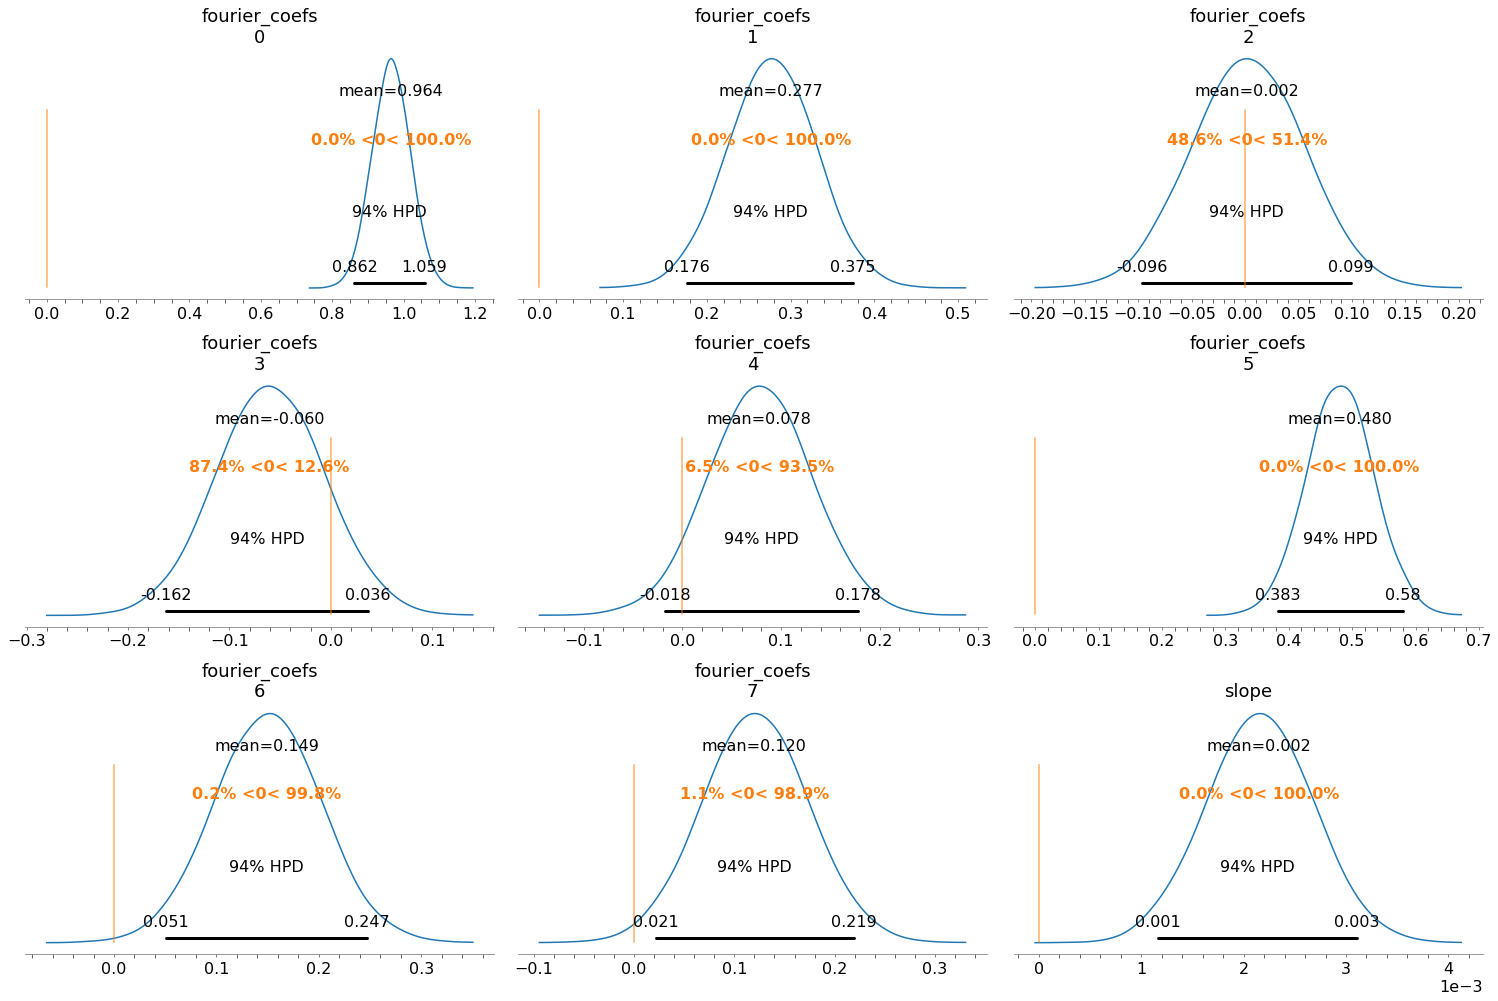

In [64]:
vars_ = ['fourier_coefs', 'slope',]
pm.plot_posterior(trace_m3f4, var_names=vars_, ref_val=0, round_to=3);

In [66]:
m3_f3 = pm.Model()
mdl_trend_season(m3_f3, n_fourier=3)

In [76]:
with m3_f3:
    trace_m3f3 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, intercept, slope, fourier_coefs]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:22<00:00, 1780.55draws/s]


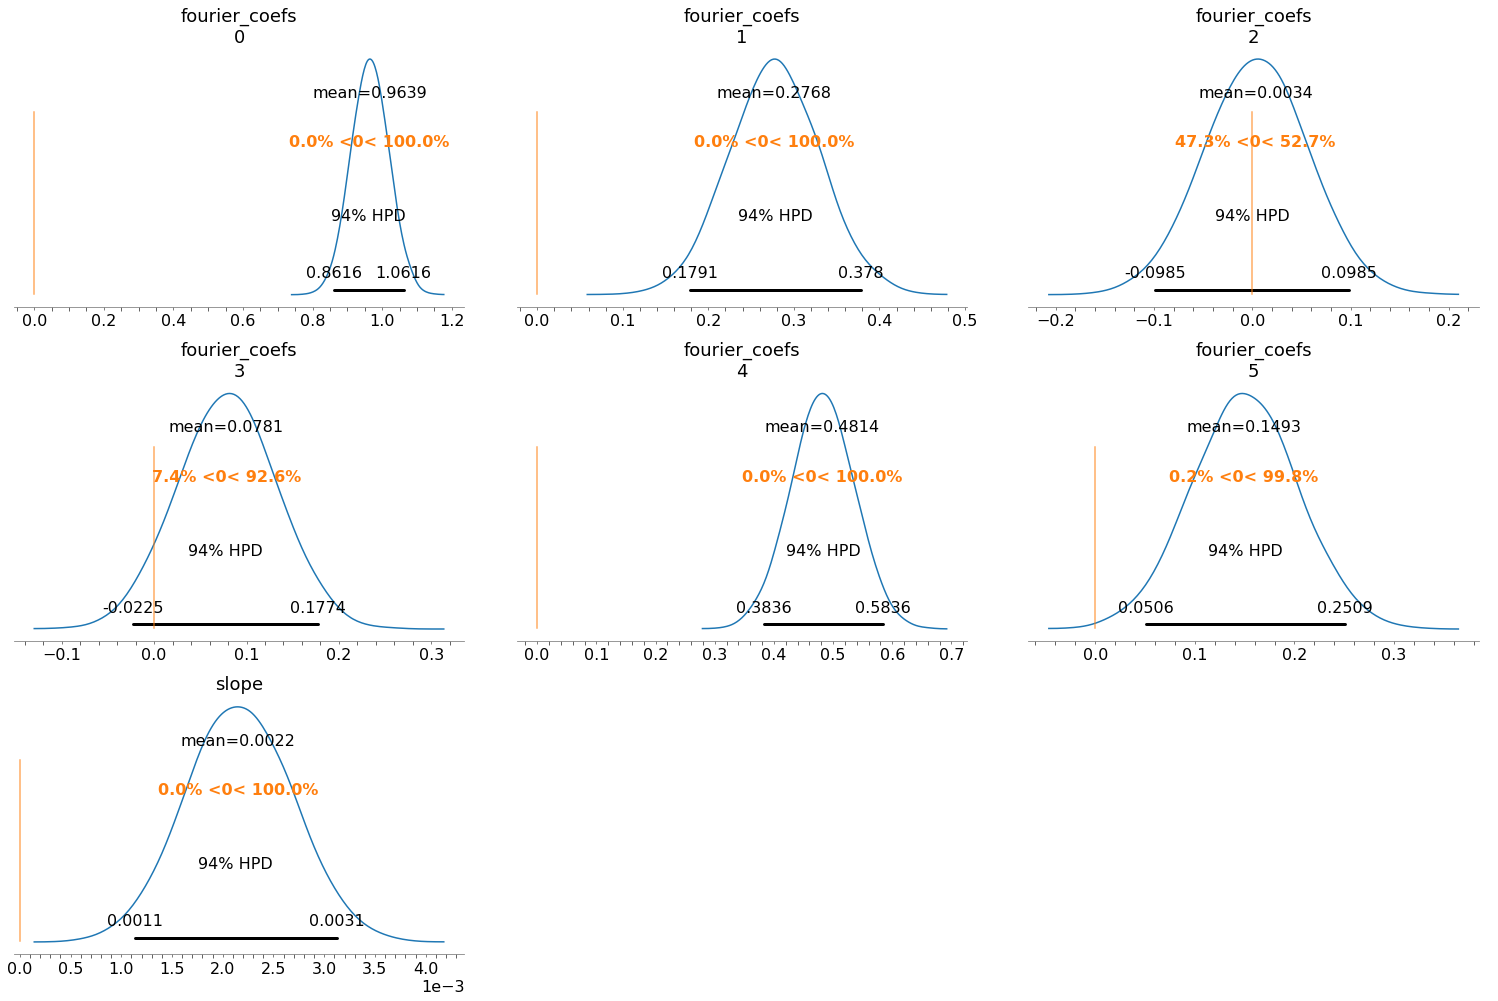

In [77]:
pm.plot_posterior(trace_m3f3, var_names=vars_, ref_val=0, round_to=4);

In [69]:
m3_f4.name ='m3_trend&fourierN4'
m3_f3.name = 'm3_trend&fourierN3'

In [78]:
pm.compare({m3_f4: trace_m3f4, m3_f3: trace_m3f3, }, ic='LOO')

/accounts/ekarakoy/anaconda3/envs/bayesian_toa_project/lib/python3.7/site-packages/pymc3/stats.py:168: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)


LOO   pLOO  dLOO weight     SE   dSE shape_warn
m3_trend&fourierN4  448.02  10.57     0   0.73  23.25     0          0
m3_trend&fourierN3  450.94   8.75  2.93   0.27  23.34  5.05          0

The difference is not quite convincing so I'll keep both models for the overall comparison:

In [80]:
dict_final_comparison.update({m3_f3: trace_m3f3, m3_f4: trace_m3f4, })

### Trend + Season + Residual

In [81]:
m4_f4 = pm.Model()
mdl_trend_season_ar1(m4_f4, n_fourier=4)

In [ ]:
pm.model_to_graphviz(m4_f4)

In [82]:
with m4_f4:
    trace_m4f4 = pm.sample(5000, tune=15000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, ar1, tau, k, intercept, slope, fourier_coefs]
Sampling 4 chains: 100%|██████████| 80000/80000 [03:00<00:00, 442.98draws/s] 
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 1.456565031128782e-58, but should be close to 0.8. Try to increase the number of tuning steps.
There were 606 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6946625250777428, but should be close to 0.8. Try to increase the number of tuning steps.
There were 635 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7056971914394191, but should be close to 0.8. Try to increase the number of tuning steps.
There were 754 divergences after tuning

In [ ]:
m4_f3 = pm.Model()
mdl_trend_season_ar1(m4_f3, n_fourier=3)
with m4_f3:
    trace_m4f3 = pm.sample(5000, tune=15000)

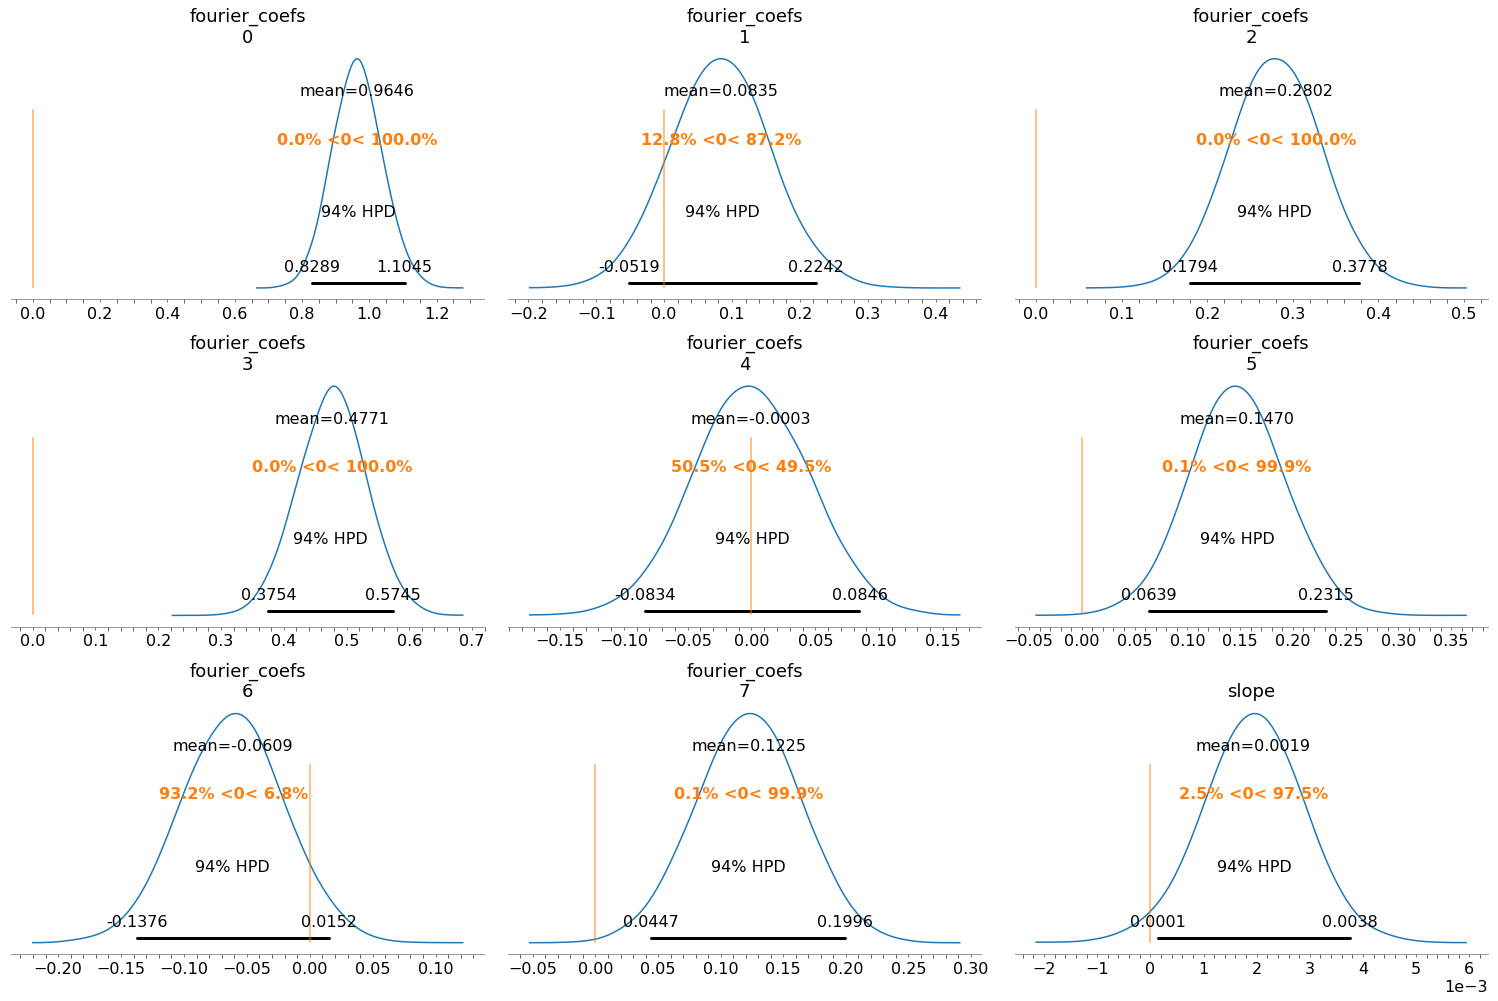

In [79]:
pm.plot_posterior(trace_m4f4, var_names=vars_, ref_val=0, round_to=4);

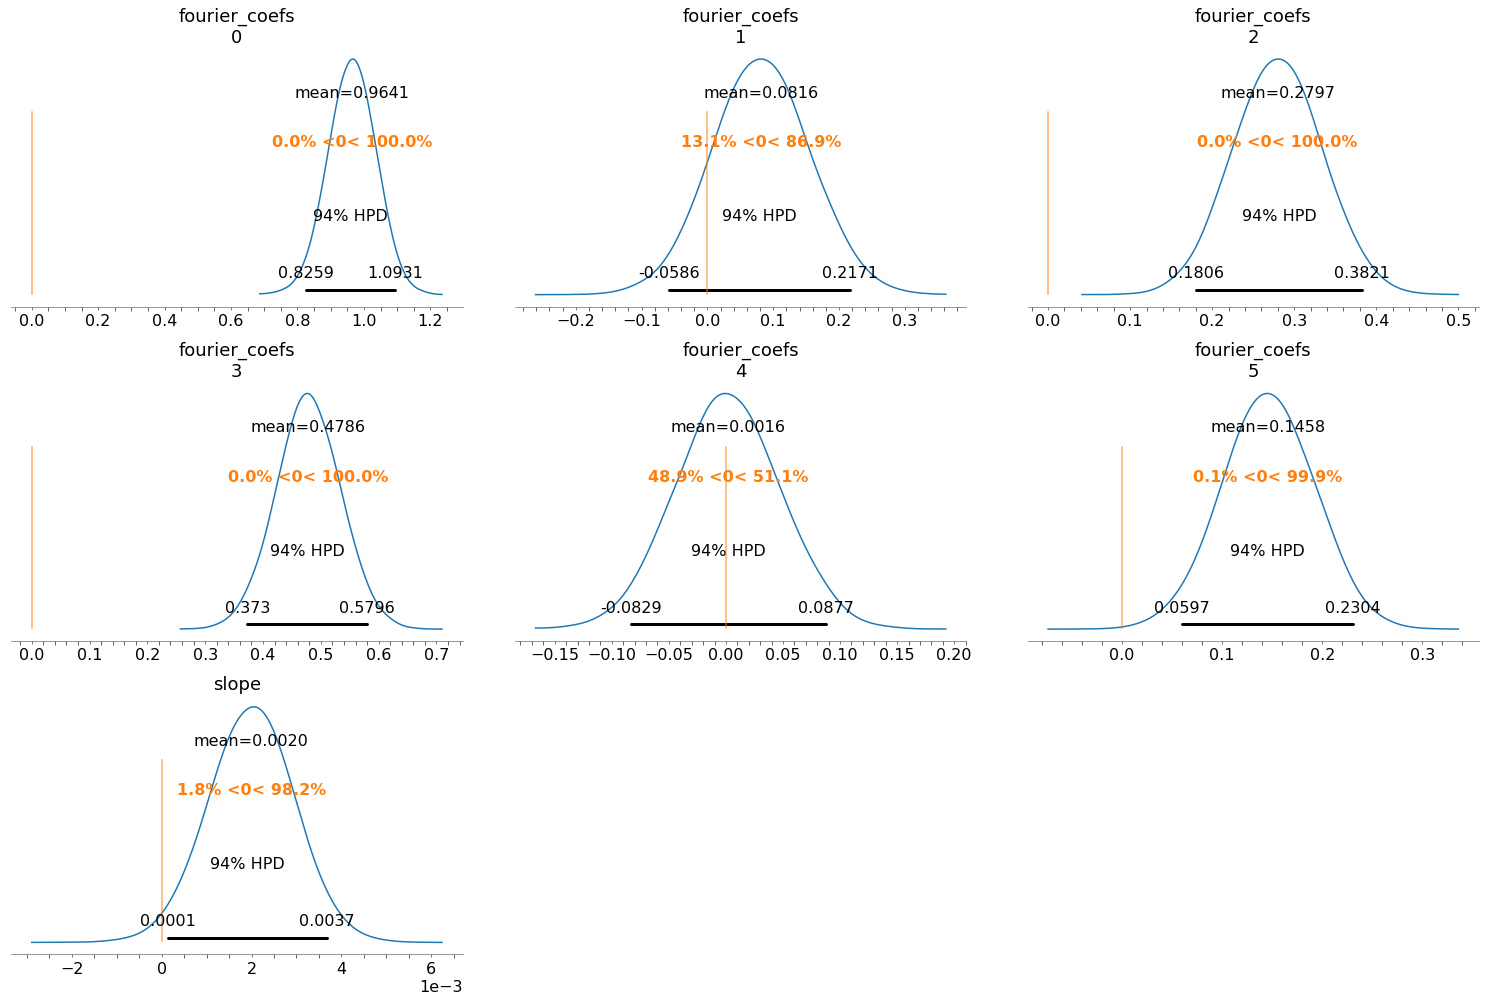

In [81]:
pm.plot_posterior(trace_m4f3, var_names=vars_, ref_val=0, round_to=4);

In [93]:
m4_f4.name='trend&fourier4&ar1'
m4_f3.name='trend&fourier3&ar1'

In [95]:
pm.compare({m4_f4: trace4_f4, m4_f3:trace4_f3})

/accounts/ekarakoy/anaconda3/envs/bayesian_toa_project/lib/python3.7/site-packages/pymc3/stats.py:168: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/accounts/ekarakoy/anaconda3/envs/bayesian_toa_project/lib/python3.7/site-packages/pymc3/stats.py:300: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


LOO    pLOO   dLOO weight     SE   dSE shape_warn
trend&fourier4&ar1  349.92  131.05      0      1   17.7     0          1
trend&fourier3&ar1  364.21   132.6  14.28      0  19.24  6.74          1

Keeping the model with 4 fourier components:

In [96]:
dict_compare_final.update({m4_f4: trace4_f4})

In [99]:
pm.compare({m3_f1: trace_3f1, m3_f3: trace_3f3, })

TypeError: Missing required input: k_interval__

Compare and select all models so far written

In [113]:
ts_mod_4 = trace_4.get_values('mu')
ts_mod_4_mu = ts_mod_4.mean(axis=0)
ts_mod_4_hpd = pm.hpd(ts_mod_4)
ts_mod_4_trend = trace_4.get_values('trend')
ts_mod_4_trend_mu = ts_mod_4_trend.mean(axis=0)
ts_mod_4_trend_hpd = pm.hpd(ts_mod_4_trend)
ts_mod_4_season = trace_4.get_values('season')
ts_mod_4_season_mu = ts_mod_4_season.mean(axis=0)
ts_mod_4_season_hpd = pm.hpd(ts_mod_4_season)
ts_mod_4_ar1 = trace_4.get_values('ar1')
ts_mod_4_ar1_mu = ts_mod_4_ar1.mean(axis=0)
ts_mod_4_ar1_hpd = pm.hpd(ts_mod_4_ar1)

In [114]:
def plot_component(axi, x, y, hpd_=None, obs=None, line_label=None, y_axis_label=None,
                  ax_title=None):
    
    if isinstance(obs, np.ndarray):
        axi.plot(x, obs, color='k', label='observations')
    axi.plot(x, y, color='darkblue', label=line_label)
    if isinstance(hpd_, np.ndarray):
        axi.fill_between(x, hpd_[:, 0], hpd_[:, 1], color='steelblue',
                         alpha=0.5, label='95% CI')
    if y_axis_label:
        axi.set_ylabel(y_axis_label)
    axi.legend()
    if ax_title:
        axi.set_title(ax_title)
    axi.xaxis_date()
    axi.xaxis.set_major_locator(years)
    axi.xaxis.set_minor_locator(months)
    axi.tick_params(axis='x', labelrotation=30)
    axi.grid()

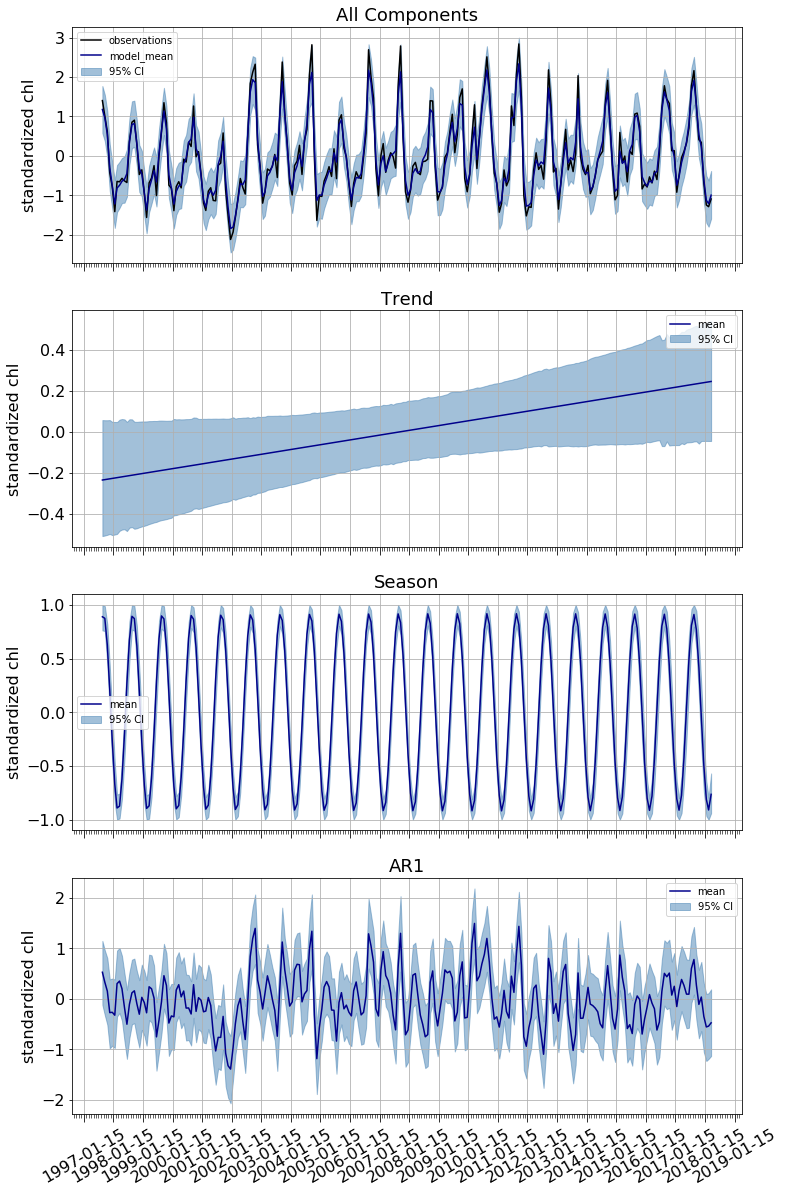

In [116]:
f, ax = pl.subplots(nrows=4, sharex=True, figsize=(12, 20))

ylbl = 'standardized chl'
plot_component(ax[0], d_aostz.index, ts_mod_4_mu, hpd_=ts_mod_4_hpd,
               obs=y_s, line_label='model_mean', y_axis_label=ylbl,
               ax_title='All Components')
plot_component(ax[1], d_aostz.index, ts_mod_4_trend_mu, hpd_=ts_mod_4_trend_hpd,
               line_label='mean', y_axis_label=ylbl, ax_title='Trend')
plot_component(ax[2], d_aostz.index, ts_mod_4_season_mu, hpd_=ts_mod_4_season_hpd,
               line_label='mean', y_axis_label=ylbl,
              ax_title='Season')
plot_component(ax[3], d_aostz.index, ts_mod_4_ar1_mu, hpd_=ts_mod_4_ar1_hpd,
              line_label='mean', y_axis_label=ylbl, ax_title='AR1')

#### Inverse transform results of models where standardized data was used

In [117]:
mod4_mu_us = std_scaler.inverse_transform(ts_mod_4_mu)
mod4_hpd_us = std_scaler.inverse_transform(ts_mod_4_hpd)
mod4_trend_hpd_us = std_scaler.inverse_transform(ts_mod_4_trend_hpd)
mod4_trend_mu_us = std_scaler.inverse_transform(ts_mod_4_trend_mu)
mod4_season_hpd_us = std_scaler.inverse_transform(ts_mod_4_season_hpd)
mod4_season_mu_us = std_scaler.inverse_transform(ts_mod_4_season_mu)
mod4_ar1_hpd_us = std_scaler.inverse_transform(ts_mod_4_ar1_hpd)
mod4_ar1_mu_us = std_scaler.inverse_transform(ts_mod_4_ar1_mu)

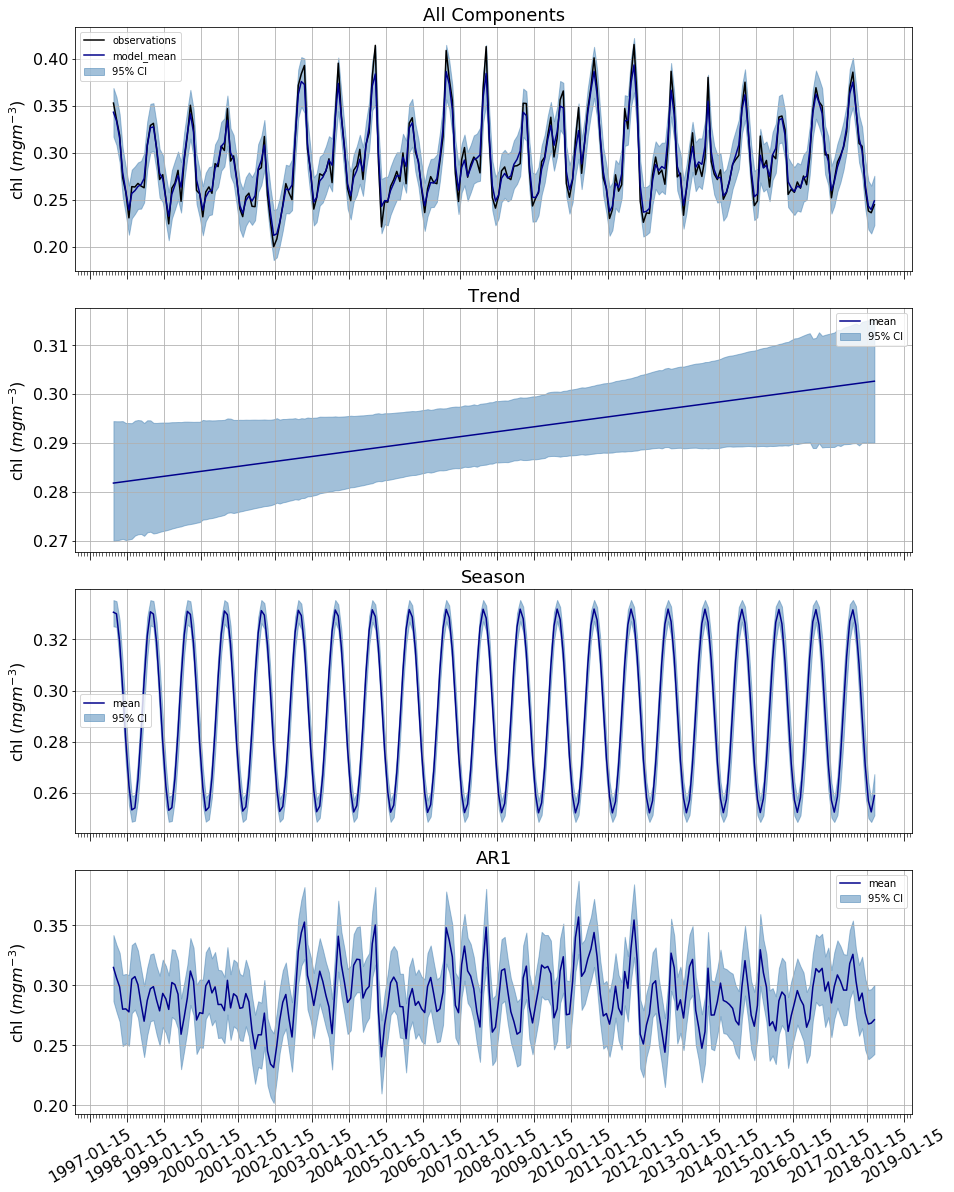

In [120]:
f, ax = pl.subplots(nrows=4, sharex=True, figsize=(15, 20))
plot_component(ax[0], d_aostz.index, mod4_mu_us, hpd_=mod4_hpd_us,
               obs=y, line_label='model_mean',
               y_axis_label='chl $(mg m^{-3})$', ax_title='All Components')
plot_component(ax[1], d_aostz.index, mod4_trend_mu_us, hpd_=mod4_trend_hpd_us,
               line_label='mean', y_axis_label='chl $(mg m^{-3})$',
              ax_title='Trend')
plot_component(ax[2], d_aostz.index, mod4_season_mu_us, hpd_=mod4_season_hpd_us,
               line_label='mean', y_axis_label='chl $(mg m^{-3})$',
              ax_title='Season')
plot_component(ax[3], d_aostz.index, mod4_ar1_mu_us, hpd_=mod4_ar1_hpd_us,
              line_label='mean', y_axis_label='chl $(mg m^{-3})$', ax_title='AR1')
f.subplots_adjust(hspace=0.15)

In [121]:
pm.summary(trace_4, var_names=vars_)

mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff  \
intercept -0.235627  0.143825  0.003040 -0.508702  0.056463  2213.325831   
slope      0.001943  0.001017  0.000020 -0.000068  0.003934  2309.361144   
amp        0.923157  0.056201  0.000812  0.815722  0.999994  5024.418309   
k          0.489240  0.070586  0.000899  0.353786  0.629992  5713.613825   
tau        3.426348  0.493778  0.007132  2.507752  4.396493  5060.550056   
thresh     0.442741  0.278891  0.005672  0.000062  0.966938  2087.077726   
wl         1.905675  0.003887  0.000069  1.897961  1.913024  2810.873374   

               Rhat  
intercept  1.000190  
slope      1.000022  
amp        1.000534  
k          1.001168  
tau        1.000032  
thresh     1.000229  
wl         1.000813

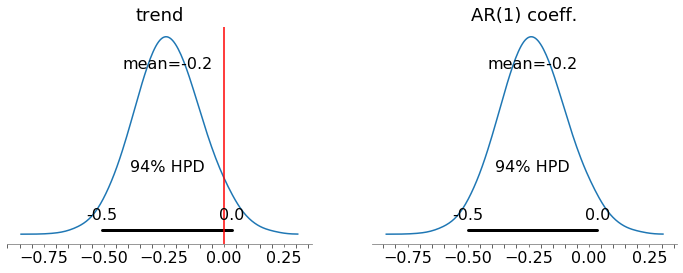

In [131]:
f, axs = pl.subplots(ncols=2, figsize=(12, 4))
pm.plot_posterior(trace_4, var_names=['trend', 'k'], ax=axs, text_size=16, );
axs[0].set_title('trend')
axs[0].axvline(color='r')
axs[1].set_title('AR(1) coeff.');
#f.savefig('./figJar/model4_posterior_dists.png', dpi=300)

In [125]:
with pm.Model() as m5:
    # overall estimation
    nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    nu_ = nuMinusOne + 1
    lam_ = pm.Gamma('lam', 10, 2)
    
    # seasonality estimation
    phase = pm.DiscreteUniform('phase', 0, 11, shape=2)
    amp = pm.HalfNormal('amp', 5, shape=2)
    cycle_1 = pm.Uniform('cycle_1', 11, 13)
    cycle_2 = pm.Uniform('cycle_2', 5, 7)
    season_1 = amp[0] * tt.cos((2 * PI * x / cycle_1) - phase[0])
    season_2 = amp[1] * tt.cos((2 * PI * x / cycle_2) - phase[1])
    season = pm.Deterministic('season', season_1 + season_2)
    
    # trend estimation
    slp = pm.Normal('slope', 0, 1)
    itc = pm.Normal('intercept', 0, 1)
    trend = pm.Deterministic('trend', itc + slp * x)
       
    # residual estimation
    k_ = pm.Uniform('k', -1.1, 1.1)
    tau_ = pm.Gamma('tau', 10, 3)
    ar1 = pm.AR1('ar1', k=k_, tau_e=tau_, shape=y.size)

    #e_t = pm.Normal('e_t', 0, 1, shape=y.size)
    #mu_ = trend + season + e_t
    mu_ = pm.Deterministic('mu_', trend + season + ar1)
    y_lik = pm.StudentT('y_lik', mu=mu_, lam=lam_, nu=nu_, observed=y_s)    

In [126]:
with m5:
    trace_5 = pm.sample(10000, tune=10000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [ar1, tau, k, intercept, slope, cycle_2, cycle_1, amp, lam, nuMinusOne]
>Metropolis: [phase]
Sampling 2 chains: 100%|██████████| 40000/40000 [05:14<00:00, 127.09draws/s]
The acceptance probability does not match the target. It is 0.8932387184013946, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [127]:
vars_ = ['intercept', 'slope', 'amp', 'phase', 'cycle_1' ,'cycle_2', 'k', 'tau']
pm.traceplot(trace_5, var_names=vars_);

In [178]:
dft5 = pm.summary(trace_5)

In [180]:
dft5.loc[dft5.Rhat>=1.4]

mean        sd  mc_error   hpd_2.5  hpd_97.5     n_eff       Rhat
phase  3.239477  2.731951  0.272014  1.169907  8.239232  2.013667  12.367996

In [65]:
ts_mod_5 = trace_5.get_values('mu_')
ts_mod_5_mu = ts_mod_5.mean(axis=0)
ts_mod_5_hpd = pm.hpd(ts_mod_5)
ts_mod_5_trend = trace_5.get_values('trend')
ts_mod_5_trend_mu = ts_mod_5_trend.mean(axis=0)
ts_mod_5_trend_hpd = pm.hpd(ts_mod_5_trend)
ts_mod_5_season = trace_5.get_values('season')
ts_mod_5_season_mu = ts_mod_5_season.mean(axis=0)
ts_mod_5_season_hpd = pm.hpd(ts_mod_5_season)
ts_mod_5_ar1 = trace_5.get_values('ar1')
ts_mod_5_ar1_mu = ts_mod_5_ar1.mean(axis=0)
ts_mod_5_ar1_hpd = pm.hpd(ts_mod_5_ar1)

In [71]:
mod5_mu_us = std_scaler.inverse_transform(ts_mod_5_mu)
mod5_hpd_us = std_scaler.inverse_transform(ts_mod_5_hpd)
mod5_trend_hpd_us = std_scaler.inverse_transform(ts_mod_5_trend_hpd)
mod5_trend_mu_us = std_scaler.inverse_transform(ts_mod_5_trend_mu)
mod5_season_hpd_us = std_scaler.inverse_transform(ts_mod_5_season_hpd)
mod5_season_mu_us = std_scaler.inverse_transform(ts_mod_5_season_mu)
mod5_ar1_hpd_us = std_scaler.inverse_transform(ts_mod_5_ar1_hpd)
mod5_ar1_mu_us = std_scaler.inverse_transform(ts_mod_5_ar1_mu)
f, ax = pl.subplots(nrows=4, sharex=True, figsize=(12, 20))
plot_component(ax[0], d_iostz.index, ts_mod_5_mu, hpd_=ts_mod_5_hpd,
               obs=y_s, line_label='model_mean',
               y_axis_label='chl $(mg m^-3)$', ax_title='All Components')
plot_component(ax[1], d_iostz.index, ts_mod_5_trend_mu, hpd_=ts_mod_5_trend_hpd,
               line_label='mean', y_axis_label='chl $(mg m^-3)$',
              ax_title='Trend')
plot_component(ax[2], d_iostz.index, ts_mod_5_season_mu, hpd_=ts_mod_5_season_hpd,
               line_label='mean', y_axis_label='chl $(mg m^-3)$',
              ax_title='Season')
plot_component(ax[3], d_iostz.index, ts_mod_5_ar1_mu, hpd_=ts_mod_5_ar1_hpd,
              line_label='mean', y_axis_label='chl $(mg m^-3)$', ax_title='AR1')

In [69]:
pm.summary(trace_5, var_names=vars_)

mean        sd  mc_error    hpd_2.5   hpd_97.5         n_eff  \
intercept  -0.702773  0.226080  0.003271  -1.155062  -0.269016   4582.773666   
slope       0.009147  0.002464  0.000033   0.004332   0.014028   4829.893189   
amp__0      0.667671  0.110026  0.001155   0.450880   0.884505   8872.234845   
amp__1      0.393080  0.079475  0.000726   0.235134   0.549326  15881.738046   
thresh1    10.480064  0.469853  0.004725   9.573454  11.410631  12139.127125   
thresh2    11.552481  0.319111  0.002500  10.936431  12.193348  17125.299113   
wl_1        1.941707  0.011422  0.000106   1.919245   1.964353  11516.422607   
wl_2        0.955897  0.003947  0.000034   0.948013   0.963453  15734.391590   

               Rhat  
intercept  1.000160  
slope      1.000418  
amp__0     1.000059  
amp__1     1.000081  
thresh1    1.000228  
thresh2    1.000086  
wl_1       1.000208  
wl_2       1.000164

#### Modeling w/ missing data imputation

In [126]:
df[['IOSTZ']].resample('MS').mean().info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 160 entries, 1997-09-01 to 2010-12-01
Freq: MS
Data columns (total 1 columns):
IOSTZ    155 non-null float64
dtypes: float64(1)
memory usage: 2.5 KB


In [144]:
y_w_nan = np.ma.array(data=df.IOSTZ.resample('MS').mean(),
                      mask=df.IOSTZ.resample('MS').mean().isnull(),
                     fill_value=-999)
nan_scaler = namedtuple('nan_scaler', ['mean_', 'std_'])
nan_scaler.mean_ = y_w_nan.mean()
nan_scaler.std_ = y_w_nan.std()
y_w_nan_s = (y_w_nan - nan_scaler.mean_) / nan_scaler.std_

In [146]:
with pm.Model() as m4i:
    """This model includes missing data imputation"""
    # overall estimation
    nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    nu_ = nuMinusOne + 1
    lam_ = pm.Gamma('lam', 10, 2)
    
    # seasonality estimation
    thresh = pm.Uniform('thresh', 0, 11)
    amp = pm.Uniform('amp', 0, 1)
    wl_ = pm.Uniform('wl', wl_lower, wl_upper)
    season = pm.Deterministic('season', amp * tt.cos((x - thresh)/ wl_))
    
    
    # trend estimation
    slp = pm.Normal('slope', 0, 1)
    itc = pm.Normal('intercept', 0, 1)
    trend = pm.Deterministic('trend', itc + slp * x)
    
    # residual estimation
    k_ = pm.Uniform('k', -1.1, 1.1)
    tau_ = pm.Gamma('tau', 10, 3)
    ar1 = pm.AR1('ar1', k=k_, tau_e=tau_, shape=y.size)
    #e_t = pm.Normal('e_t', 0, 1, shape=y.size)
    #mu_ = trend + season + e_t
    mu_ = pm.Deterministic('mu', trend + season + ar1)
    y_lik = pm.StudentT('y_lik', mu=mu_, lam=lam_, nu=nu_, observed=y_w_nan_s)

In [147]:
with m4i:
    trace_4i = pm.sample(10000, tune=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_lik_missing, ar1, tau_log__, k_interval__, intercept, slope, wl_interval__, amp_interval__, thresh_interval__, lam_log__, nuMinusOne_log__]
100%|██████████| 20000/20000 [03:02<00:00, 109.84it/s]
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.69781933688, but should be close to 0.8. Try to increase the number of tuning steps.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.71646233209, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


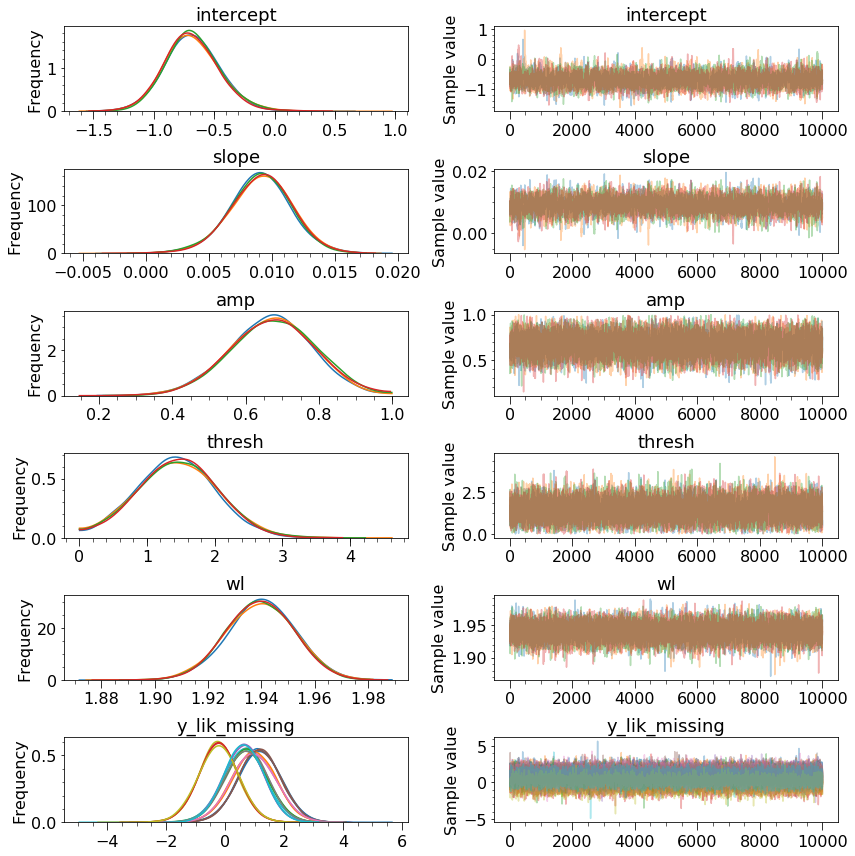

In [243]:
vars_ = ['intercept', 'slope', 'amp', 'thresh', 'wl', 'y_lik_missing']
pm.traceplot(trace_4i, varnames=vars_);

In [244]:
pm.summary(trace_4i, varnames=vars_)

mean        sd  mc_error   hpd_2.5  hpd_97.5  \
intercept        -0.678875  0.224528  0.004561 -1.112781 -0.228108   
slope             0.009113  0.002447  0.000046  0.004178  0.013920   
amp               0.672759  0.114928  0.001340  0.441977  0.892130   
thresh            1.447370  0.584646  0.006425  0.289872  2.574037   
wl                1.939780  0.012613  0.000140  1.915247  1.964524   
y_lik_missing__0  1.166311  0.710226  0.004355 -0.219344  2.560616   
y_lik_missing__1  0.977485  0.743502  0.004838 -0.492352  2.421179   
y_lik_missing__2  0.711867  0.707809  0.004417 -0.682458  2.093423   
y_lik_missing__3 -0.222968  0.656253  0.003800 -1.539396  1.040424   
y_lik_missing__4  0.637990  0.663471  0.003682 -0.668910  1.927358   

                         n_eff      Rhat  
intercept          3116.003596  1.000485  
slope              3576.453879  1.000292  
amp                7069.847140  1.000799  
thresh             8414.914112  1.000438  
wl                 8984.735723  1.000503  
y_lik_missing__0  23333.505362  1.000090  
y_lik_missing__1  21163.169051  1.000011  
y_lik_missing__2  21569.211968  1.000060  
y_lik_missing__3  30058.771240  1.000005  
y_lik_missing__4  32088.705741  0.999994

In [192]:
d_iostz_s = (df.IOSTZ  - df.IOSTZ.mean()) / df.IOSTZ.std()
d_iostz_si = d_iostz_s.resample('MS').mean().interpolate()

In [198]:
np.argwhere(y_w_nan_s.mask)

array([[124],
       [125],
       [126],
       [130],
       [140]])

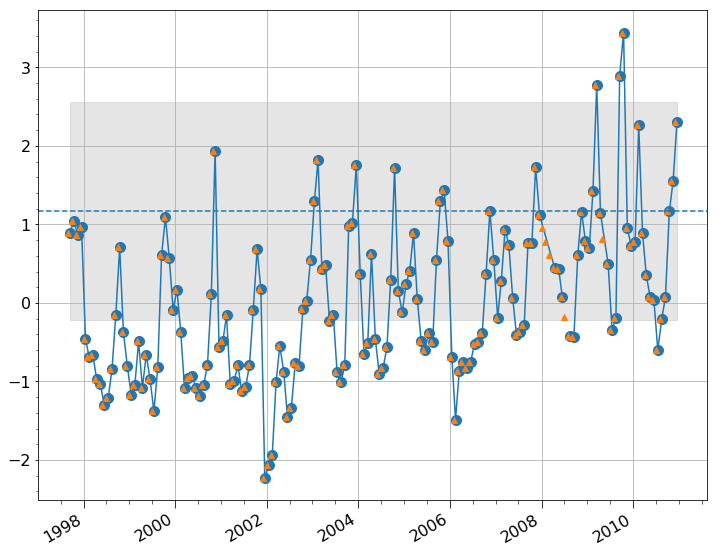

In [202]:
_, ax = pl.subplots(figsize=(12, 10))

d_iostz_s.plot(marker='o', markersize=10, ax=ax)
d_iostz_si.plot(marker='^', ls='', ax=ax)
ax.grid()
ax.axhline(y=1.166, ls='--')
ax.fill_between(d_iostz_s.index, y1=-0.219, y2=2.561, color='gray', alpha=0.2)

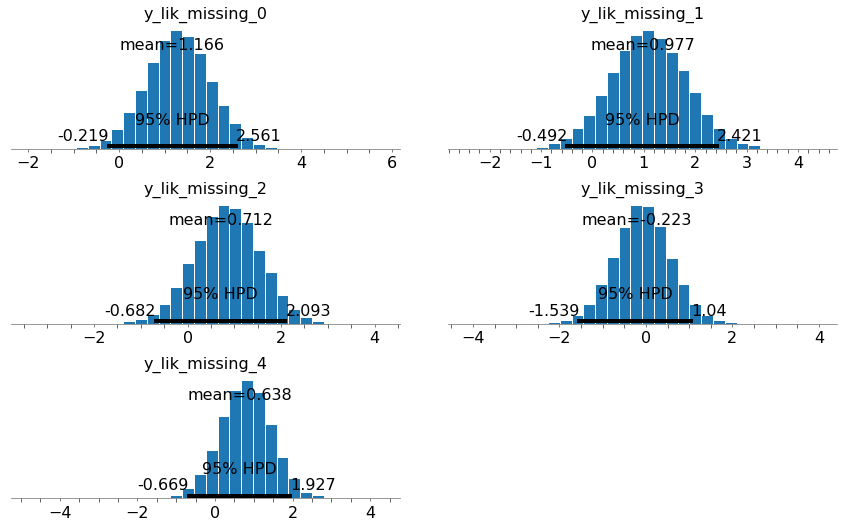

In [185]:
pm.plot_posterior(trace_4i, varnames=['y_lik_missing'],text_size=16);

In [166]:
with pm.Model() as m5i:
    # overall estimation
    nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    nu_ = nuMinusOne + 1
    lam_ = pm.Gamma('lam', 10, 2)
    
    # seasonality estimation
    thresh = pm.Normal('thresh', 10, shape=2)
    amp = pm.HalfNormal('amp', 5, shape=2)
    wl = pm.Uniform('wl_1', 0, 5, shape=2)
    season_1 = amp[0] * tt.sin((x - thresh[0]) / wl[0])
    season_2 = amp[1] * tt.sin((x - thresh[1]) / wl[1])
    season = pm.Deterministic('season', season_1 + season_2)
    
    # trend estimation
    slp = pm.Normal('slope', 0, 1)
    itc = pm.Normal('intercept', 0, 1)
    trend = pm.Deterministic('trend', itc + slp * x)
       
    # residual estimation
    k_ = pm.Uniform('k', -1.1, 1.1)
    tau_ = pm.Gamma('tau', 10, 3)
    ar1 = pm.AR1('ar1', k=k_, tau_e=tau_, shape=y.size)

    #e_t = pm.Normal('e_t', 0, 1, shape=y.size)
    #mu_ = trend + season + e_t
    mu_ = pm.Deterministic('mu_', trend + season + ar1)
    y_lik = pm.StudentT('y_lik', mu=mu_, lam=lam_, nu=nu_, observed=y_w_nan_s)    

In [162]:
with m5i:
    trace_5i = pm.sample(10000, tune=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_lik_missing, ar1, tau_log__, k_interval__, intercept, slope, wl_2_interval__, wl_1_interval__, amp_log__, thresh2, thresh1, lam_log__, nuMinusOne_log__]
100%|██████████| 20000/20000 [04:49<00:00, 69.07it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [165]:
vars_ = ['intercept', 'slope', 'amp', 'thresh1', 'thresh2', 'wl_1', 'wl_2',
         'y_lik_missing']
pm.traceplot(trace_5i, varnames=vars_);

### Local linear  modeling

In [217]:
numobs = y_s.size

In [219]:
with pm.Model() as m6:
    delta_t = pm.GaussianRandomWalk('delta_t', mu=0, sd=1, shape=numobs)
    y_t = pm.Normal('y_t', mu=delta_t, sd=1, observed=y_s)

In [220]:
with m6:
    trace_6 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta_t]
100%|██████████| 10000/10000 [00:23<00:00, 425.11it/s]


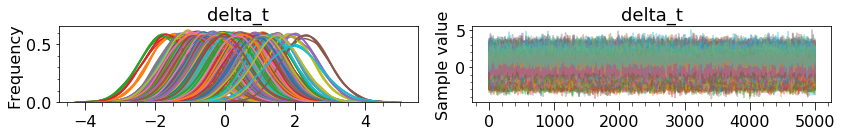

In [223]:
pm.traceplot(trace_6);

In [227]:
y_ppc6 = pm.sample_ppc(trace_6, model=m6)['y_t']

100%|██████████| 5000/5000 [00:00<00:00, 6327.71it/s]


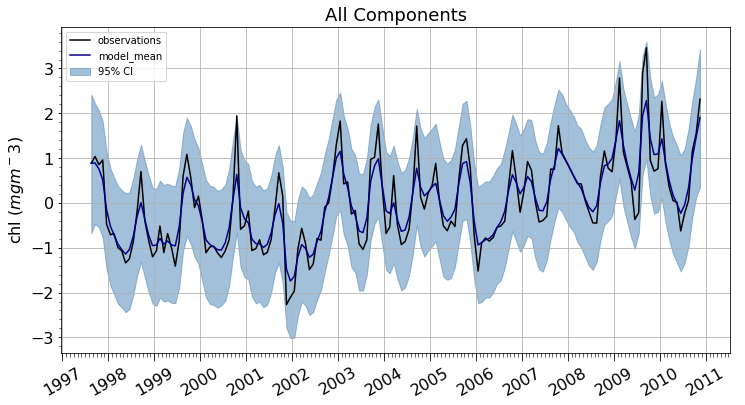

In [222]:
ts_mod_6 = trace_6.get_values('delta_t')
ts_mod_6_mu = ts_mod_6.mean(axis=0)
ts_mod_6_hpd = pm.hpd(ts_mod_6)
_, ax = pl.subplots(figsize=(12, 6))
plot_component(ax, d_iostz.index, ts_mod_6_mu, hpd_=ts_mod_6_hpd,
               obs=y_s, line_label='model_mean',
               y_axis_label='chl $(mg m^-3)$', ax_title='All Components')

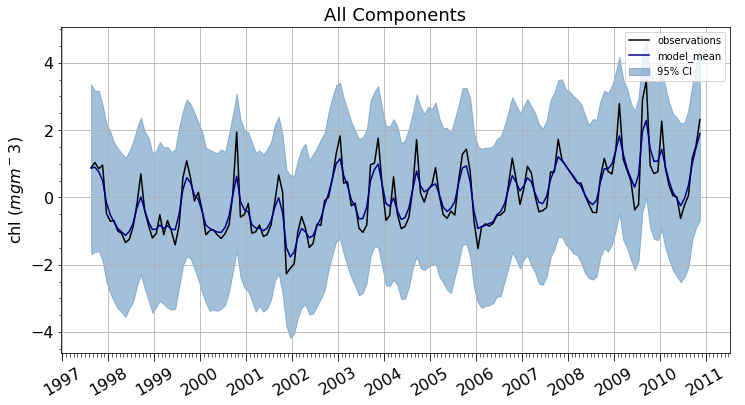

In [231]:
y_m6 = y_ppc6.mean(axis=0)
hpd6 = pm.hpd(y_ppc6)
_, ax = pl.subplots(figsize=(12, 6))
plot_component(ax, d_iostz.index, y_m6, hpd_=hpd6,
               obs=y_s, line_label='model_mean',
               y_axis_label='chl $(mg m^-3)$', ax_title='All Components')

### Local linear trend modeling

In [224]:
with pm.Model() as m7:
    delta_t = pm.GaussianRandomWalk('delta_t', mu=0, sd=1, shape=numobs-1)
    nu_t = pm.GaussianRandomWalk('nu_t', mu=delta_t, sd=1, shape=numobs)
    y_t = pm.Normal('y_t', mu=nu_t, sd=1, observed=y_s)

In [225]:
with m7:
    trace_7 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_t, delta_t]
100%|██████████| 10000/10000 [00:19<00:00, 505.28it/s]


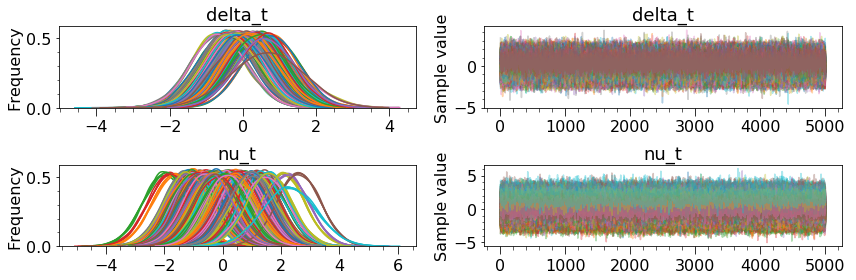

In [226]:
pm.traceplot(trace_7);

In [232]:
y_ppc7 = pm.sample_ppc(trace_7, model=m7)['y_t']

100%|██████████| 5000/5000 [00:00<00:00, 6284.92it/s]


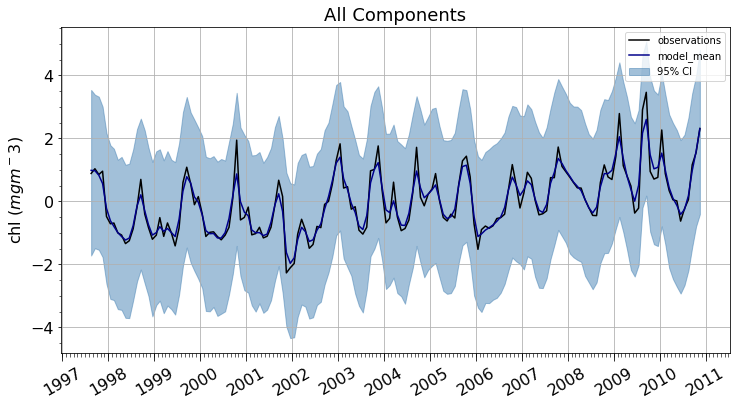

In [233]:
y_m7 = y_ppc7.mean(axis=0)
hpd7 = pm.hpd(y_ppc7)
_, ax = pl.subplots(figsize=(12, 6))
plot_component(ax, d_iostz.index, y_m7, hpd_=hpd7,
               obs=y_s, line_label='model_mean',
               y_axis_label='chl $(mg m^-3)$', ax_title='All Components')

### Pickle model results and scaler

In [88]:
m5.name = 'm5'
m4.name = 'm4'
m4i.name = 'm4_imputed'
m5i.name = 'm5_imputed'
resDict = dict(models=dict(m4=m4, m5=m5, m4i=m4i, m5i=m5i),
               traces=dict(m4=trace_4, m5=trace_5, m4i=trace_4i, m5i),
               scaler=std_scaler)
with open('./pikleJar/iostz_bayMdl.pkl', 'wb') as f:
    pickle.dump(resDict, f)

'm5'

In [79]:
resDict.keys(), resDict['models'].keys(), resDict['traces'].keys()

(dict_keys(['models', 'traces', 'scaler']),
 dict_keys(['m4', 'm5']),
 dict_keys(['m4', 'm5']))

In [94]:
pm.compare({m4:trace_4, m5:trace_5})

/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC  pWAIC  dWAIC weight     SE   dSE var_warn
m5  239.66  73.83      0      1  20.75     0        1
m4  254.37  77.72  14.71      0  20.88  5.75        1

In [95]:
pm.compare({m4:trace_4, m5:trace_5}, ic='LOO')

/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:292: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


LOO   pLOO   dLOO weight     SE   dSE shape_warn
m5  268.39  88.19      0      1  21.25     0          1
m4  286.86  93.96  18.47      0  21.22  6.28          1


 #### <u>Piecewise trend model</u>